In [16]:
path = './'
nombre_foto = 'c2e000'
x_calibracion = 4.5
ancho_corte = 5

How many peaks do you want to analyse? 3


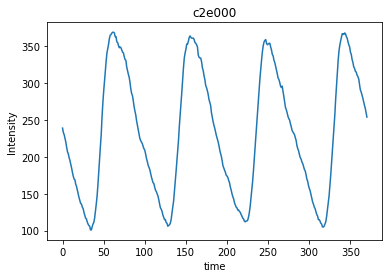

In [56]:
from PIL import Image             # funciones para cargar y manipular imágenes
import numpy as np                # funciones numéricas (arrays, matrices, etc.)
import matplotlib.pyplot as plt   # funciones para representación gráfica
%matplotlib inline
import cv2
from matplotlib.pyplot import subplots
from numpy import linspace
from scipy import interpolate
from scipy.signal import argrelextrema
import pandas as pd
from pylab import lstsq
from pylab import matrix
from pylab import exp
from math import log
import random
import  csv


if __name__ == '__main__' :
# Read image
    imag = cv2.imread(path + nombre_foto + ".tif")

    if imag is None:
        print("Check file path")
    else:
        cv2.imshow ('image', imag)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cantidad_picos = int(input ('How many peaks do you want to analyse?'))

    if cantidad_picos == 0:
        pass
    else:
        # Select ROI
        fromCenter = False
        showCrosshair = False
        r = cv2.selectROI(imag, fromCenter, showCrosshair)

        # Crop image
        imCrop = imag[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        up = int(r[1])
        down = int(r[1]+r[3])
        left = int(r[0])
        right = int(r[0]+r[2])

#########################
#- Creating a log file -#
log_path = path + 'logfile.txt'

with open(log_path, 'a') as my_file:
    my_file.write('selected area pict: '+ nombre_foto + '\n' +'up: ' + str(up) + '\n'+'down: ' + str(down) + '\n'+'left: ' + str(left) + '\n'+'right: ' + str(right) + '\n')

# Display cropped image
cv2.imshow("Image", imCrop)
cv2.waitKey(0)
cv2.destroyAllWindows()


################################
### PREPARACIÓN DE LA IMAGEN ###
################################

I = Image.open(path + nombre_foto + ".tif")
a=np.asarray(I,dtype=np.float32)  # convierte el objeto I en una matriz de tipo float32
Image.fromarray(a.astype(np.uint8)).save("prueba.jpg")  # primero convierte "a" a uint8, y luego a un objeto "imagen"


######################################################################################################
###HACE CORTES DE LA IMAGEN CADA INTERVALOS DE PIXELES Y LUEGO HACE UN HISTOGRAMA DE CADA INTERVALO###
######################################################################################################

## Genera una imagen en escala de grises con la que se trabaja

#             plt.figure()
#             plt.subplot(121)
#             plt.imshow(a,cmap='gray',interpolation='nearest')
#             plt.title('Imagen') 
a = cv2.bilateralFilter(a,20,300,300)

## Corta en porciones la imagen haciendo un histograma de cada una
x_data = np.asarray(range(up,down),dtype=np.float64)
list_img_row = []

whole_cell_SI = Image.fromarray(a[up:down, left:right].astype(np.uint8))
whole_cell_data = np.sum(whole_cell_SI,axis=1).tolist()
for i in range (left, right, ancho_corte):
    #recorte de la imagen en los límites del objeto
    seleccion=a[up:down,i:i + ancho_corte]
    #análisis de cada franja
    SI = Image.fromarray(seleccion.astype(np.uint8))
    img_row_sum = np.sum(SI,axis=1).tolist() #lista de datos del histograma
    list_img_row.append (img_row_sum)
#gráfico de cada franja
#             plt.subplot(122)
#             plt.imshow(seleccion,cmap='gray',interpolation='nearest')
#             plt.title('Subframe') 
#             plt.show()
#gráfico de histograma
plt.plot(img_row_sum)
plt.title(nombre_foto)
plt.xlabel("time")
plt.ylabel("Intensity")
plt.savefig('img_row_sum')
plt.show()

In [87]:
# Función que da la posición de los picos máximos

min_distancia = input ('Time between peaks?')
def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=min_distancia)
    kk = list(indexes)
    tiempos = []
    intensidades = []
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos.append (j)
            intensidades.append (vector[j])
    return tiempos,intensidades

# Aplico la función sobre los datos de la célula entera, y devuelve valores de tiempos e intensidades de los máximos


whole_cell_picos = maximo_peak (whole_cell_data)
whole_cell_tiempos_maximos = whole_cell_picos [0]
whole_cell_intensidades_maximos = whole_cell_picos [1]

cantidad_total_picos = int (len(whole_cell_picos[0]))                             
Columns = ['Transient_'+ str(x) for x in range(0, cantidad_total_picos)]
wc = pd.DataFrame([whole_cell_tiempos_maximos,whole_cell_intensidades_maximos], columns = Columns)

# Aplico la función sobre los datos, y devuelve valores de tiempos e intensidades de los máximos

datos_tiempos = {}
datos_intensidades = {}  

for i in range (0,len(list_img_row)):

    picos = maximo_peak (list_img_row[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]

df_tiempos = pd.DataFrame(list(datos_tiempos.items()),columns = ['Rows','Picos'])
df_intensidades = pd.DataFrame(list(datos_intensidades.items()),columns = ['Rows','Picos'])
Columns = ['Pico_'+ str(x) for x in range(0, cantidad_total_picos)]
tiempos_maximos = pd.DataFrame(df_tiempos.Picos.tolist(), columns=Columns)
intensidades_maximas = pd.DataFrame(df_intensidades.Picos.tolist(), columns=Columns)

Time between peaks? 70


In [88]:
#  Detección de mínimos locales
# Calculate the n-th discrete difference along the given axis. The first difference is given by out[i] = a[i+1] - a[i] along the given axis, higher differences are calculated by using diff recursively.
# The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.

def minimo_bl (vector):
    data = np.asarray(vector,dtype=np.int)
    b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1
    return b

# Esta celda calcula los mínimos de la selección de toda la célula tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

whole_cell_tiempo0 = []
whole_cell_intensidad0 = []        
wc_tiempo_n = []
wc_intensidad_n = []
whole_cell_minimun = minimo_bl (whole_cell_data)

lista_minimos = []
for pico in  range (0, cantidad_total_picos - 1):
    lista_mins = []
    for minimo in whole_cell_minimun:
        picomenor = int(wc['Transient_'+ str (pico)][0])
        picomayor = int(wc['Transient_' + str (pico + 1)][0])
        if minimo > picomenor and minimo < picomayor:
            y_min = whole_cell_data [minimo]
            lista_mins.append((minimo,y_min))
    minimo_lista_mins = min (lista_mins, key = lambda t: t[1])
    lista_minimos.append(minimo_lista_mins)
whole_cell_tiempos_min = [x[0] for x in lista_minimos]
whole_cell_intensidades_min = [x[1] for x in lista_minimos]

lista_min = []
for minimo in whole_cell_minimun:
    picomenor = int(wc['Transient_0'][0])
    if minimo < picomenor:
        y_min = whole_cell_data [minimo]
        lista_min.append((minimo,y_min))
minimo_lista_mins = min(lista_min, key = lambda t: t[1])
whole_cell_tiempo0.append(minimo_lista_mins[0])
whole_cell_intensidad0.append (minimo_lista_mins[1])


#final minimun

# lista_min = []
# for minimo in whole_cell_minimun:
#     picomayor = int(wc['Transient_' + str (cantidad_total_picos-1)][0])
#     if minimo > picomayor:
#         y_min = whole_cell_data [minimo]
#         lista_min.append((minimo,y_min))     
# minimo_lista_mins = min(lista_min, key = lambda t: t[1])

# wc_tiempo_n.append(minimo_lista_mins[0])
# wc_intensidad_n.append (minimo_lista_mins[1])

wc_tiempos_minimos = [x for x in whole_cell_tiempos_min]
wc_tiempos_minimos.insert(0, whole_cell_tiempo0[0])
wc_intensidades_minimos = [x for x in whole_cell_intensidades_min]
wc_intensidades_minimos.insert(0, whole_cell_intensidad0[0])  


wc.loc[len(wc)] = wc_tiempos_minimos
wc.loc[len(wc)] = wc_intensidades_minimos


# Esta celda calcula los mínimos de cada subselección tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

list_b = []

for img_row_sum in list_img_row:
    minimun = minimo_bl (img_row_sum)
    list_b.append(minimun)

tiempo0 = []
intensidad0 = []
tiempos_min = []
intensidades_min = []
tiempo_n = []
intensidad_n = []
for i in range(0, len (list_b)):
    b = list_b[i]
    lista_minimos = []
    for pico in  range (0, cantidad_total_picos - 1):
        lista_mins = []
        for minimo in b:
            picomenor = int(tiempos_maximos['Pico_'+ str (pico)][i])
            picomayor = int(tiempos_maximos['Pico_' + str (pico + 1)][i])
            if minimo > picomenor and minimo < picomayor:
                y_min = list_img_row [i] [minimo]
                lista_mins.append((minimo,y_min))
        minimo_lista_mins = min (lista_mins, key = lambda t: t[1])
        lista_minimos.append(minimo_lista_mins)
    lista_tiempos = [x[0] for x in lista_minimos]
    lista_intensidad = [x[1] for x in lista_minimos]
    tiempos_min.append (lista_tiempos)
    intensidades_min.append (lista_intensidad)

    b = list_b[i]
    lista_min = []
    for minimo in b:
        picomenor = int(tiempos_maximos['Pico_0'][i])
        if minimo < picomenor:
            y_min = list_img_row [i] [minimo]
            lista_min.append((minimo,y_min))
    minimo_lista_mins = min(lista_min, key = lambda t: t[1])
    tiempo0.append(minimo_lista_mins[0])
    intensidad0.append (minimo_lista_mins[1])

    #final minimun

#     b = list_b[i]
#     lista_min = []
#     for minimo in b:
#         picomayor = int(tiempos_maximos['Pico_' + str (cantidad_total_picos - 1)][i])
#         if minimo > picomayor:
#             y_min = list_img_row [i] [minimo]
#             lista_min.append((minimo,y_min))
#     minimo_lista_mins = min(lista_min, key = lambda t: t[1])
#     tiempo_n.append(minimo_lista_mins[0])
#     intensidad_n.append (minimo_lista_mins[1])

Columns = ['Pico_'+ str(x) for x in range(1,len(tiempos_min[0])+1)]
tiempos_minimos = pd.DataFrame(tiempos_min,columns = Columns)
intensidades_minimos = pd.DataFrame(intensidades_min,columns = Columns)
tiempos_minimos['Pico_0'] = tiempo0
tiempos_minimos = tiempos_minimos.reindex(sorted(tiempos_minimos.columns), axis=1)
intensidades_minimos['Pico_0'] = intensidad0
intensidades_minimos = intensidades_minimos.reindex(sorted(intensidades_minimos.columns), axis=1)
# tiempos_minimos['Pico_n'] = tiempo_n
# intensidades_minimos['Pico_n'] = intensidad_n

In [89]:
# Calcula la amplitud de cada pico como la diferencia entre la intensidad máximo y mínimo 

whole_cell_amplitud = []
for trans in range(0, cantidad_total_picos):
    wc_amplitud = (whole_cell_intensidades_maximos [trans] - wc_intensidades_minimos [trans])/wc_intensidades_minimos [trans]
    whole_cell_amplitud.append(wc_amplitud)
wc.loc[len(wc)] = whole_cell_amplitud
print (wc)
# Calcula la amplitud de cada pico como la diferencia entre la intensidad máximo y mínimo para cada corte de selección

amplitudes = pd.DataFrame()
for peak in range  (0, cantidad_total_picos):
    amp = (intensidades_maximas ['Pico_' + str(peak)] - intensidades_minimos ['Pico_' + str(peak)])/ intensidades_minimos ['Pico_' + str(peak)]
    amplitudes['Pico_' + str(peak)] = amp
amplitudes.to_csv(path + 'amplitudes_' + nombre_foto + '.csv',sep="\t", decimal=',')

    Transient_0   Transient_1   Transient_2  Transient_3
0     69.000000    162.000000    258.000000    348.00000
1  11538.000000  11551.000000  11484.000000  11329.00000
2     36.000000    131.000000    225.000000    318.00000
3   3560.000000   3684.000000   3571.000000   3587.00000
4      2.241011      2.135451      2.215906      2.15835


In [90]:
# Cálculo del tiempo al pico como la diferencia en el tiempo máximo y mínimo para toda la selección

wc_tiempo_al_pico = []
for peak in range  (0, cantidad_total_picos):
    wc_ttp = whole_cell_tiempos_maximos [peak] - wc_tiempos_minimos [peak]
    wc_tiempo_al_pico.append(wc_ttp)
wc.loc[len(wc)] = wc_tiempo_al_pico

# Cálculo del tiempo al pico como la diferencia en el tiempo máximo y mínimo para cada corte

tiempo_al_pico = pd.DataFrame()
for peak in range  (0, cantidad_total_picos):
    ttp = tiempos_maximos ['Pico_' + str(peak)] - tiempos_minimos ['Pico_' + str(peak)]
    tiempo_al_pico['Pico_' + str(peak)] = ttp

In [91]:
# Calcula el tiempo al 50% del pico de cada pico de la selección

#             wc_tiempo_50pico = []
#             for peak in range  (0, cantidad_picos):
#                 wc_amp50 = (whole_cell_intensidades_maximos [peak] - wc_intensidades_minimos [peak])/2
#                 wc_amp50 = list (wc_amp50.astype(np.int))
#                 wc_lista_ttp50 = []
#                 for i in range (0, len (wc_amp50)):
#                     wc_lista_up = np.asarray (whole_cell_data [wc_tiempos_minimos ['Transient_' + str(peak)] : whole_cell_tiempos_maximos ['Transient_' + str(peak)]])
#                     wc_ttp50 = (np.abs(wc_lista_up - wc_amp50[i])).argmin()
#                     wc_lista_ttp50.append (wc_ttp50)
#             wc.loc[len(wc)] = wc_tiempo_50pico


# Calcula el tiempo al 50% del pico de cada pico como la diferencia entre la intensidad máximo y mínimo 
# Lo intenté buscando el valor más cercano a la mitad pero veo que me da valores negativos cuando comparo ese valor comparado con el mínimo
# Tal vez se debería probar fittear la subida para obtener el valor de la mitad a la subida.

tiempo_50pico = pd.DataFrame()
for peak in range  (0, cantidad_total_picos):
    amp50 = (intensidades_maximas ['Pico_' + str(peak)] + intensidades_minimos ['Pico_' + str(peak)])/2
    amp50 = list (amp50.astype(np.int))
    lista_ttp50 = []
    for i in range (0, len (amp50)):
        lista_up = np.asarray (list_img_row [i] [tiempos_minimos ['Pico_' + str(peak)][i] : tiempos_maximos ['Pico_' + str(peak)][i]])
        ttp50 = (np.abs(lista_up - amp50[i])).argmin()
        lista_ttp50.append (ttp50)
    tiempo_50pico ['Pico_' + str(peak)] = lista_ttp50

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


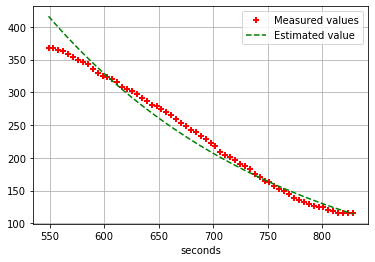

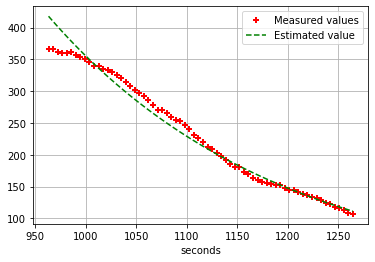

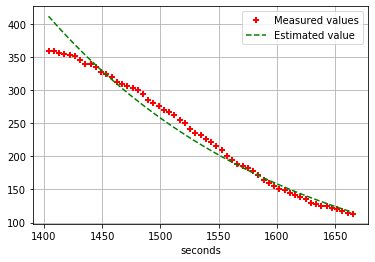

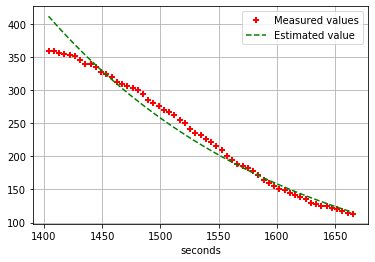

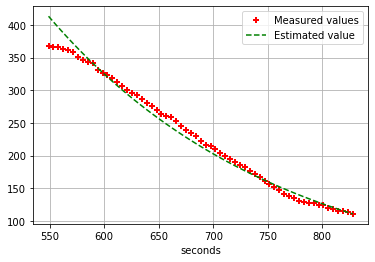

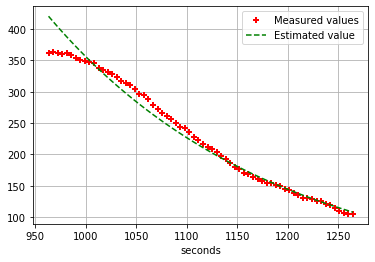

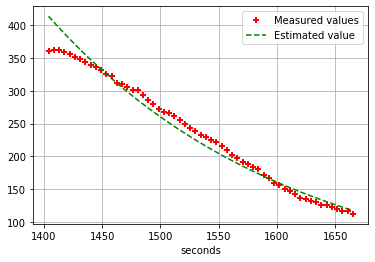

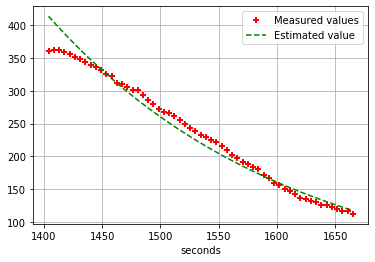

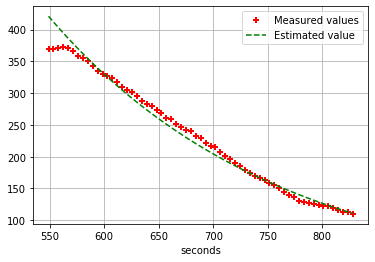

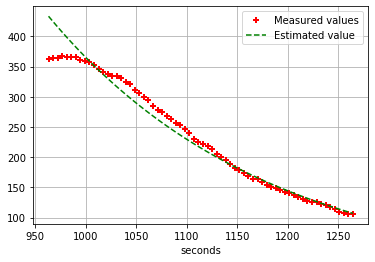

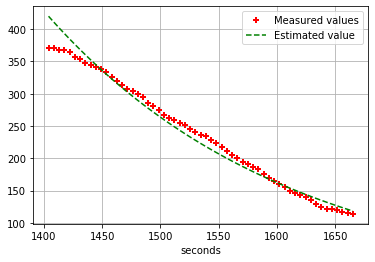

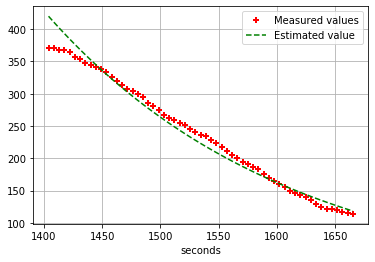

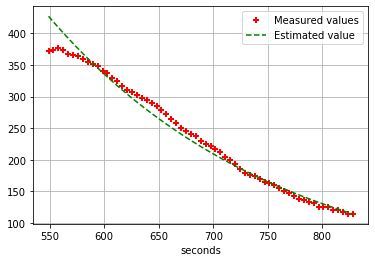

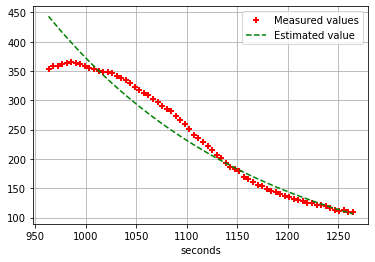

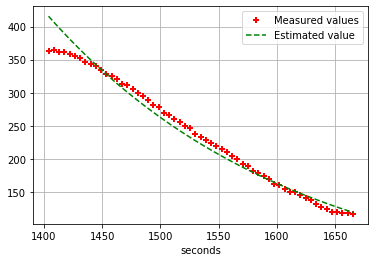

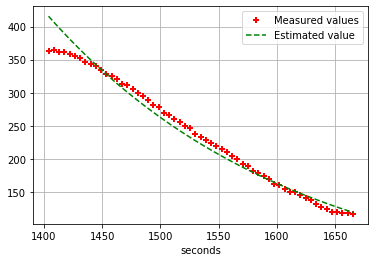

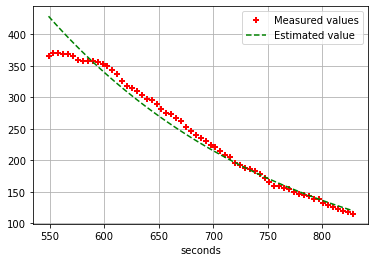

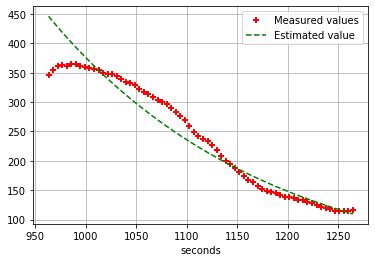

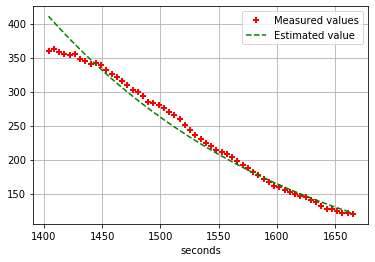

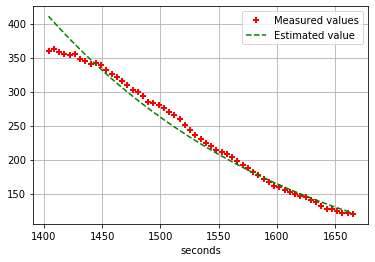

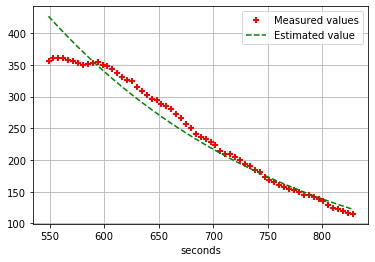

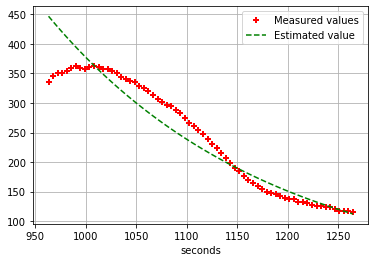

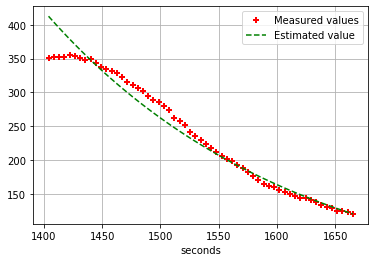

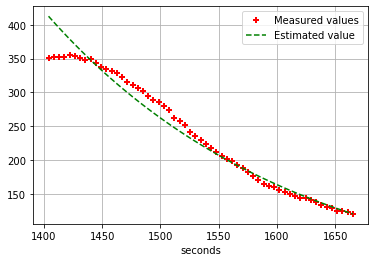

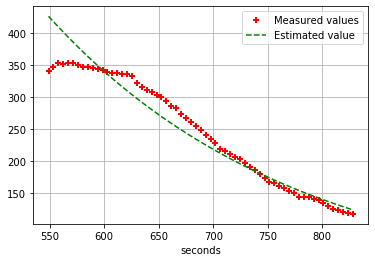

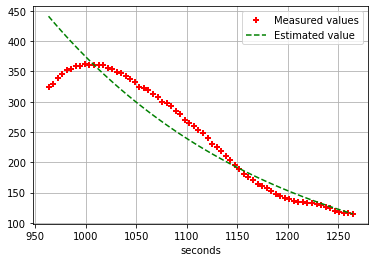

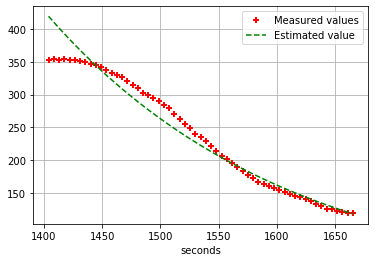

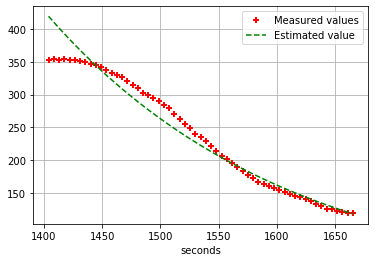

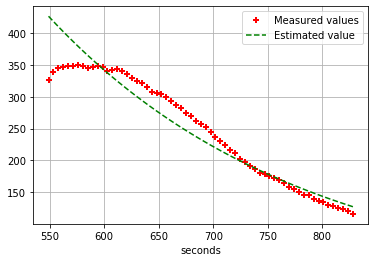

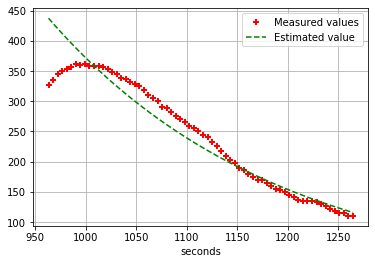

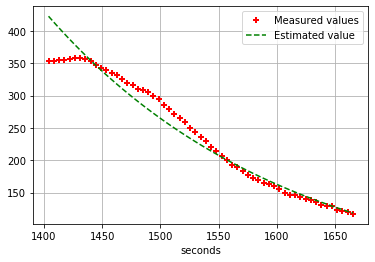

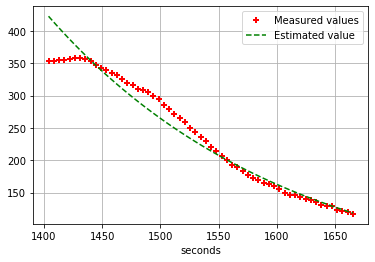

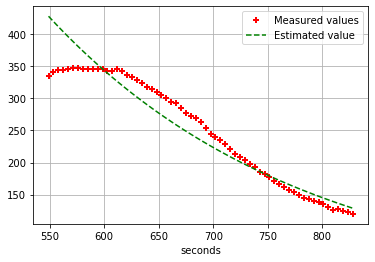

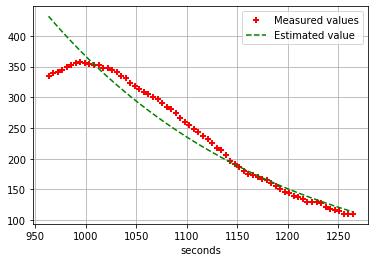

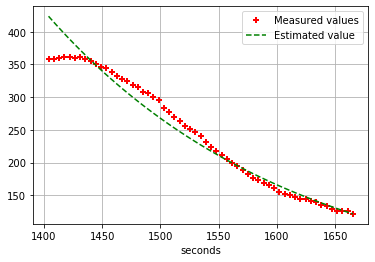

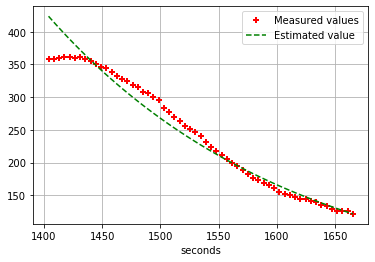

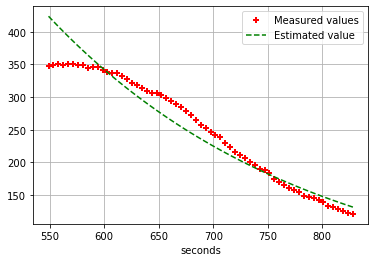

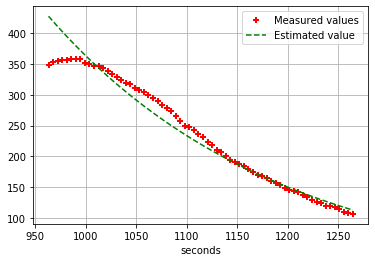

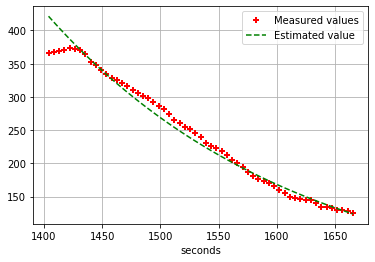

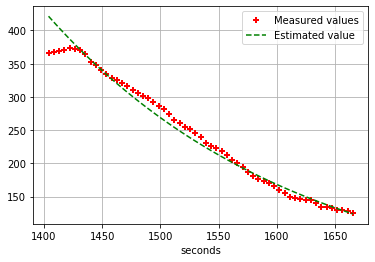

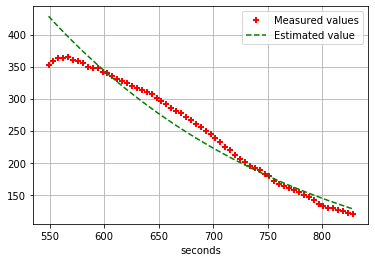

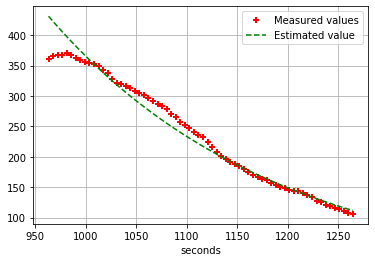

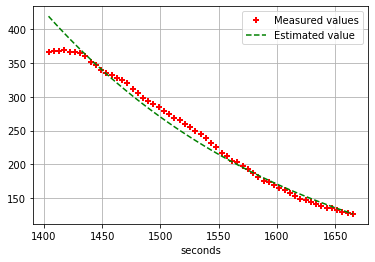

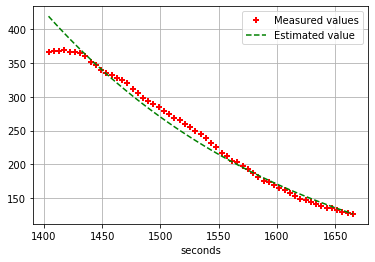

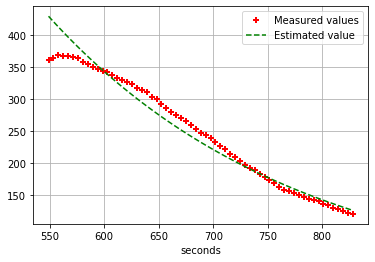

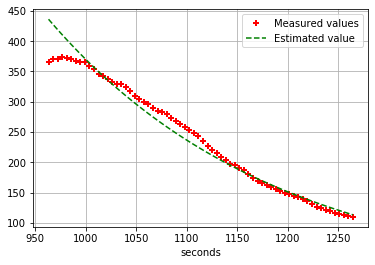

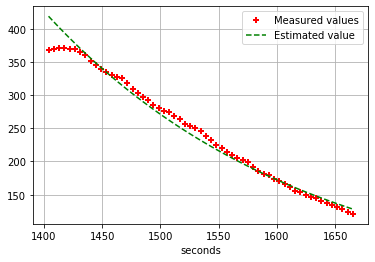

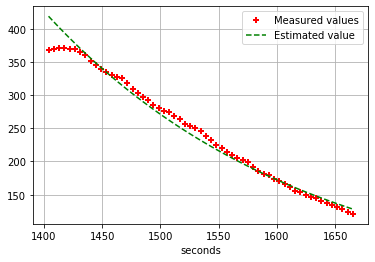

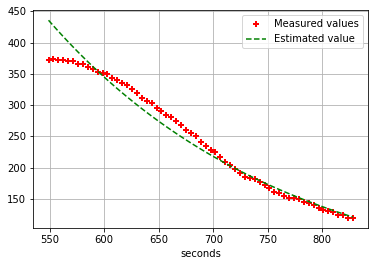

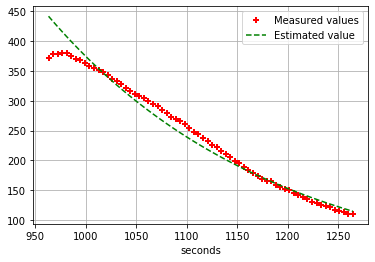

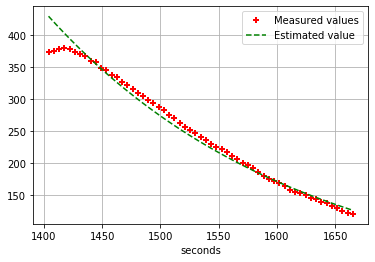

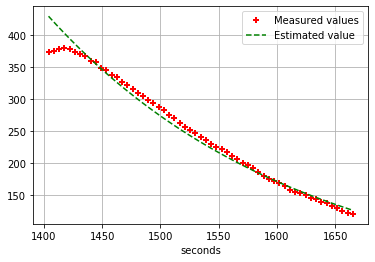

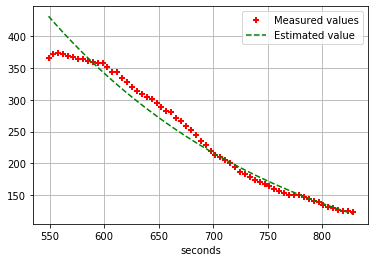

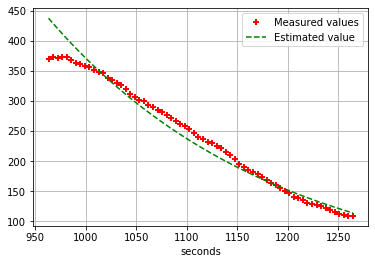

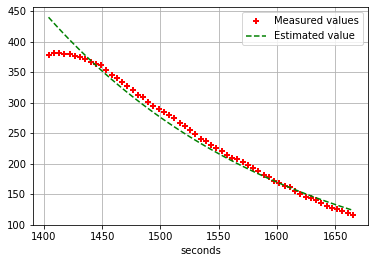

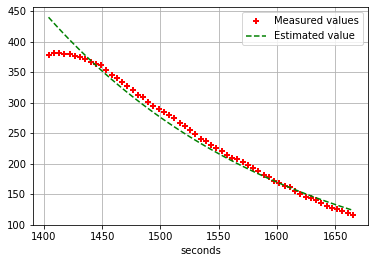

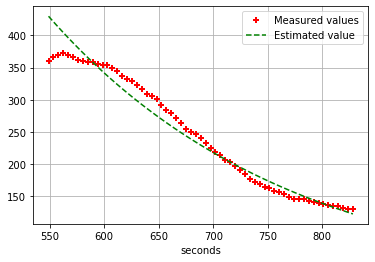

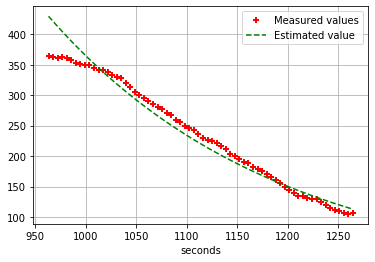

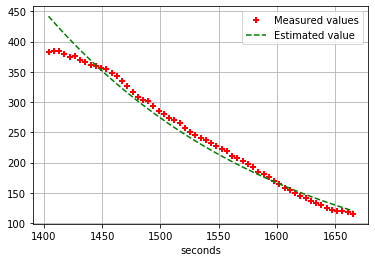

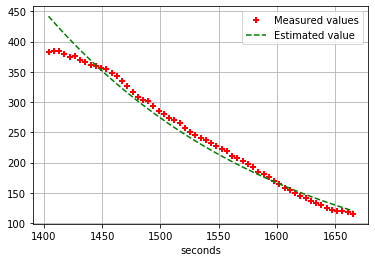

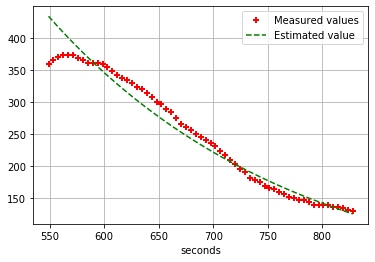

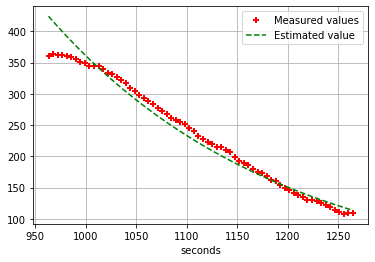

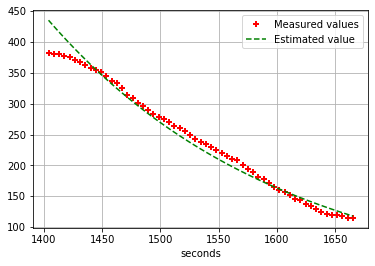

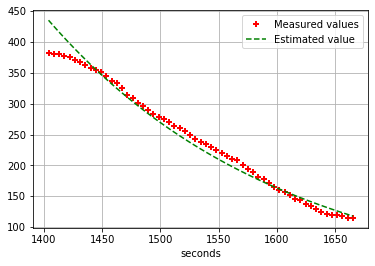

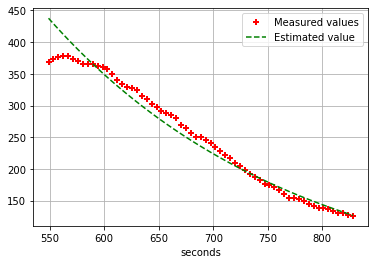

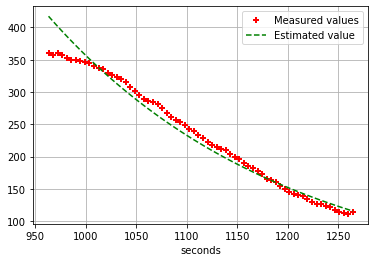

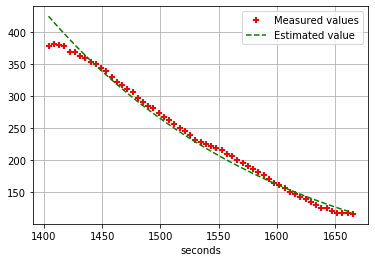

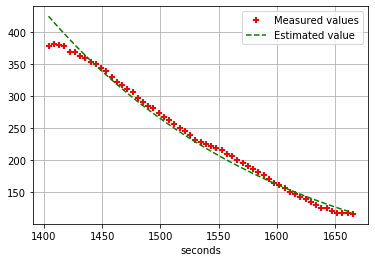

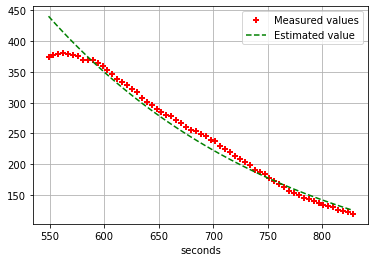

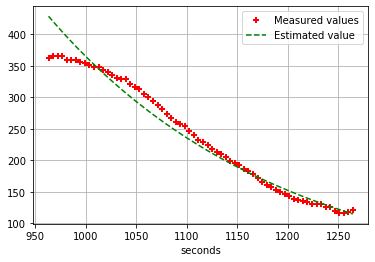

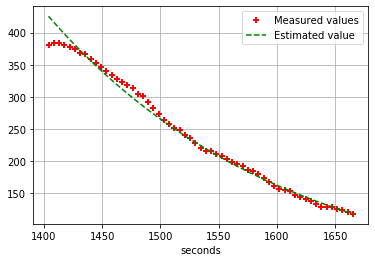

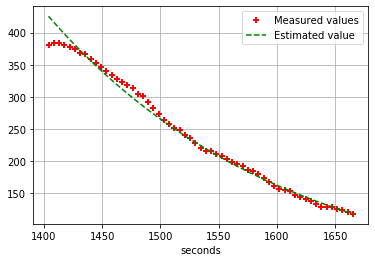

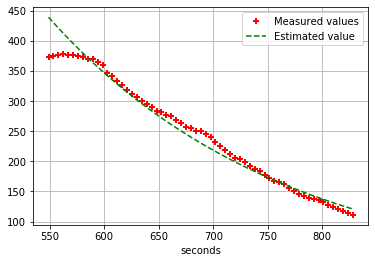

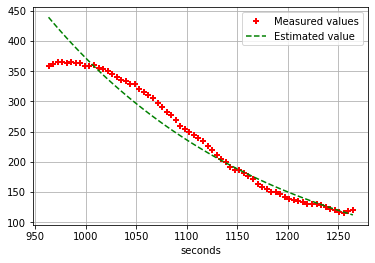

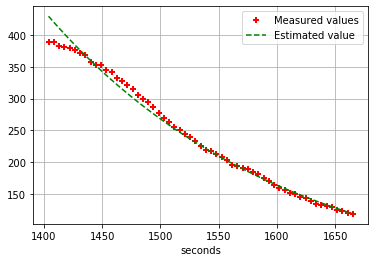

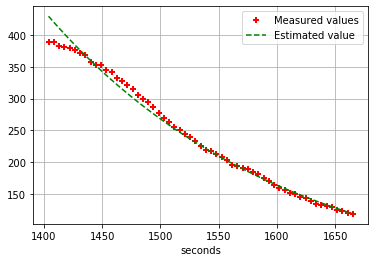

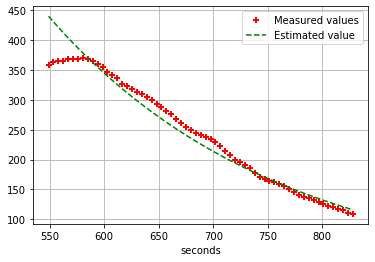

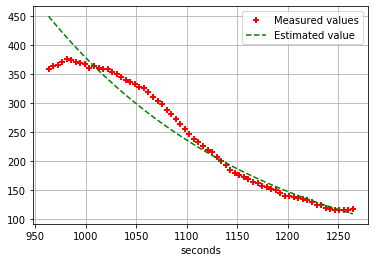

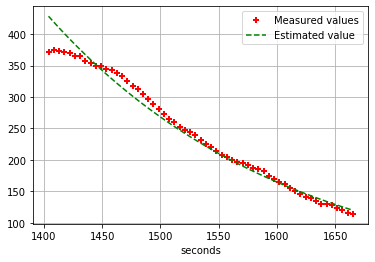

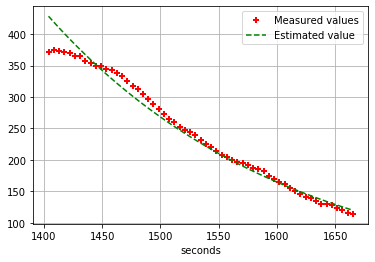

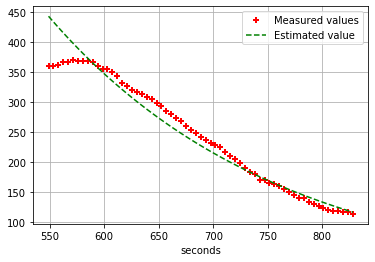

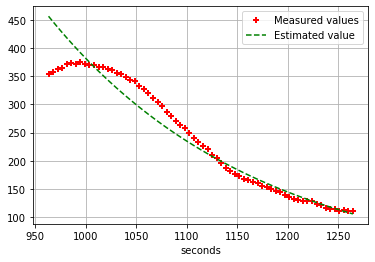

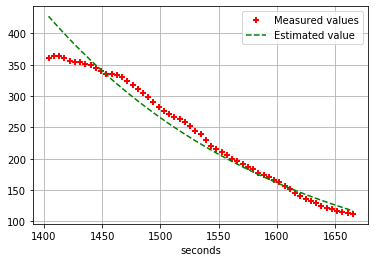

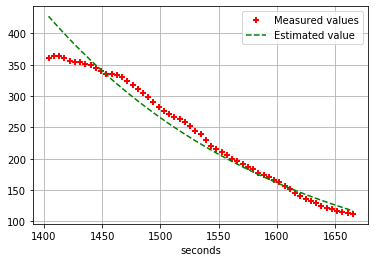

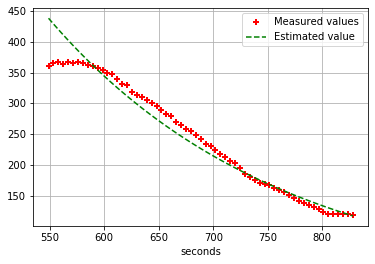

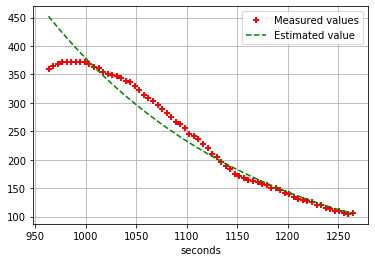

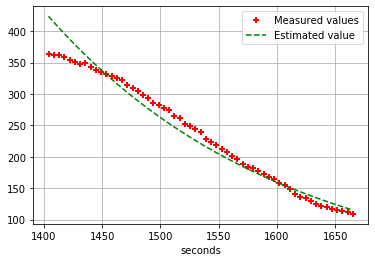

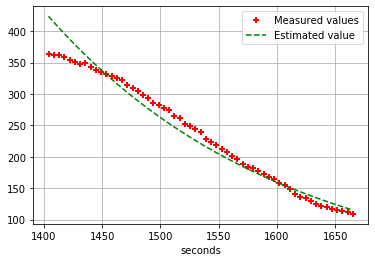

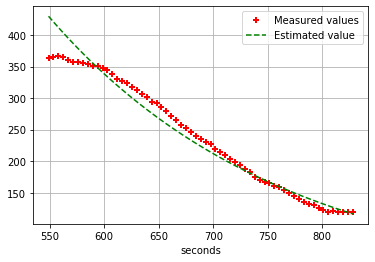

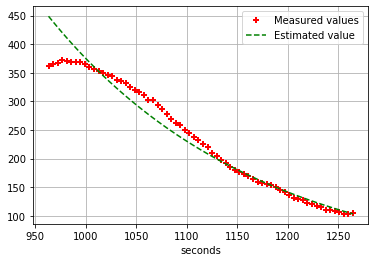

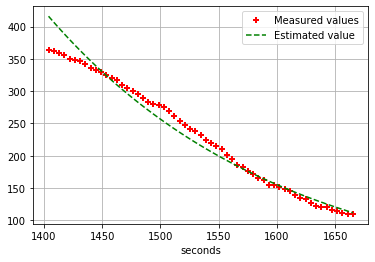

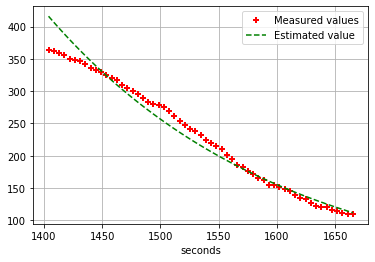

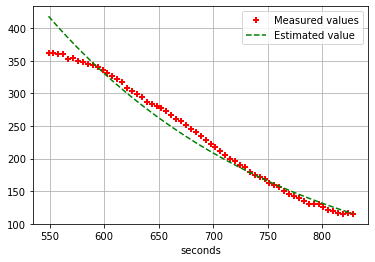

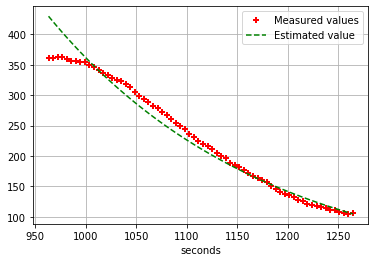

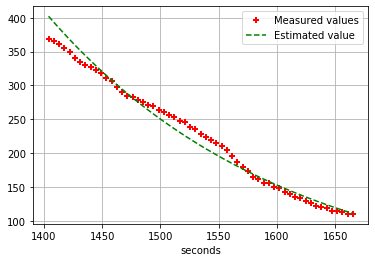

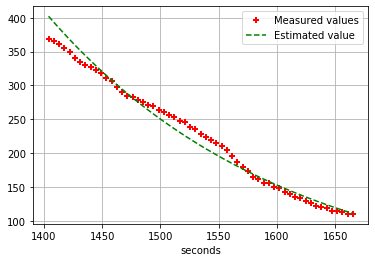

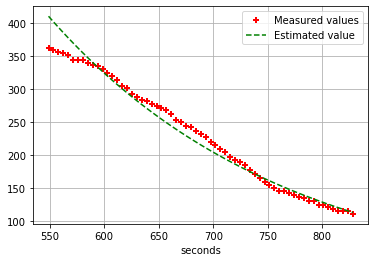

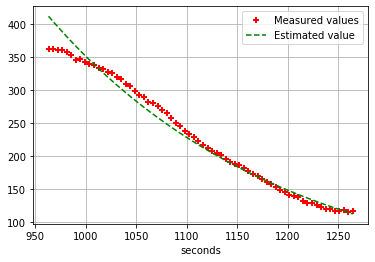

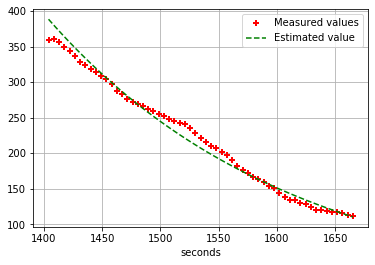

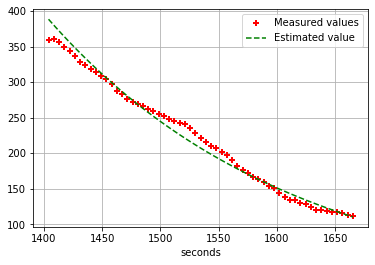

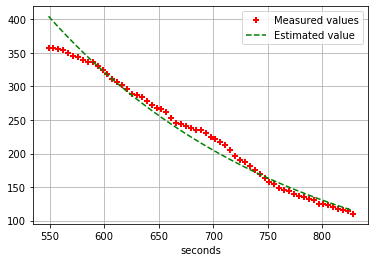

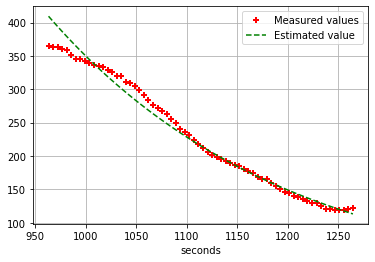

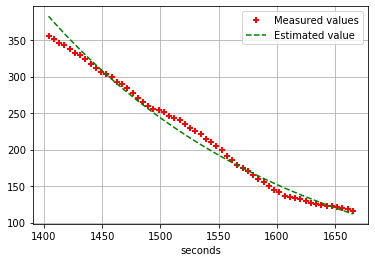

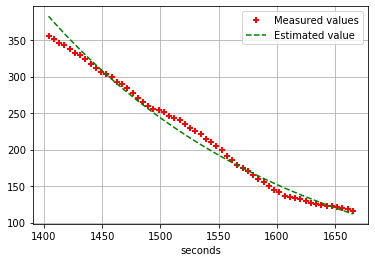

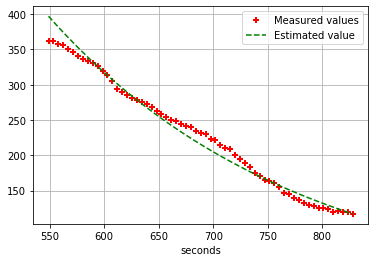

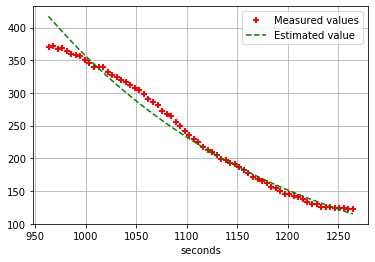

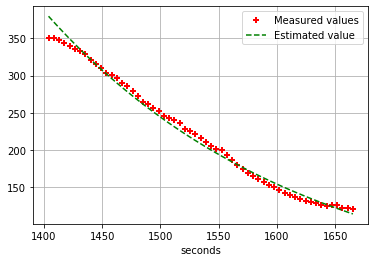

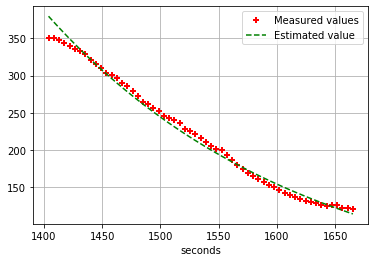

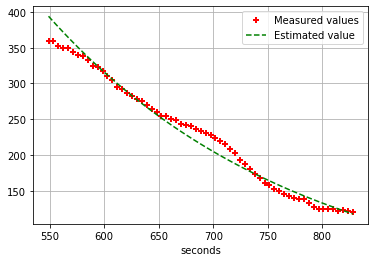

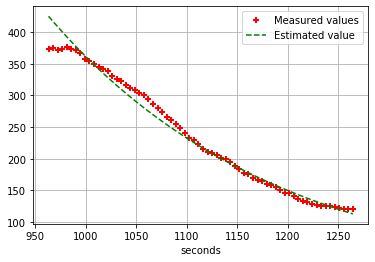

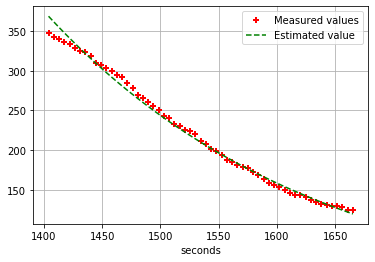

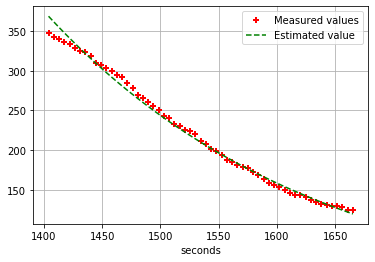

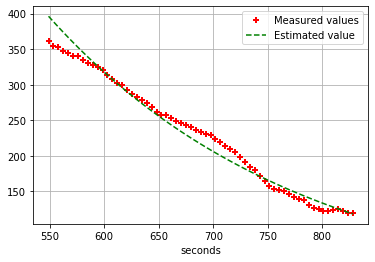

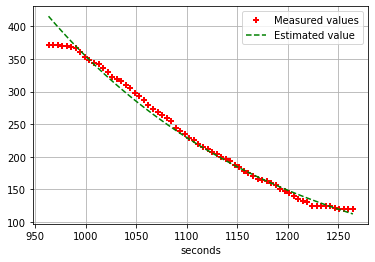

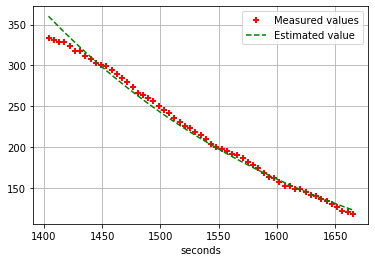

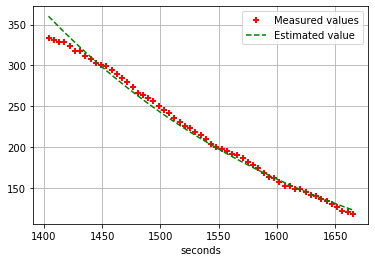

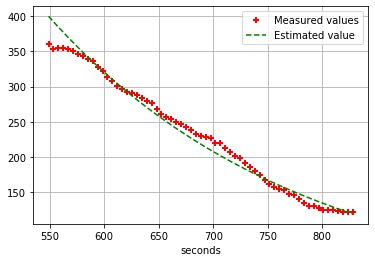

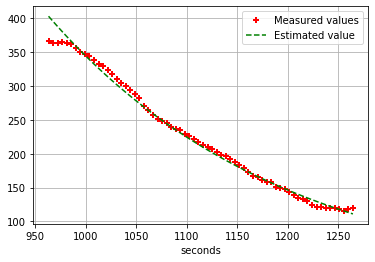

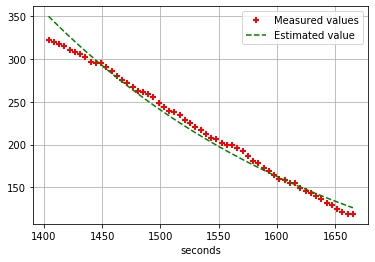

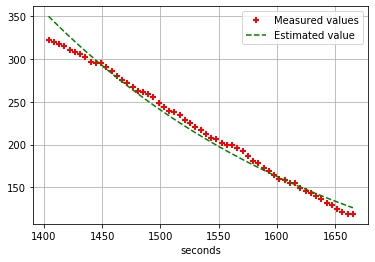

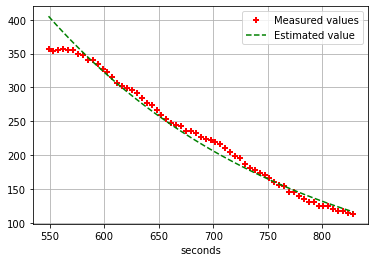

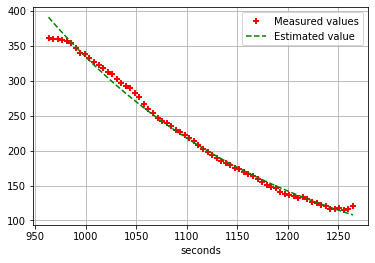

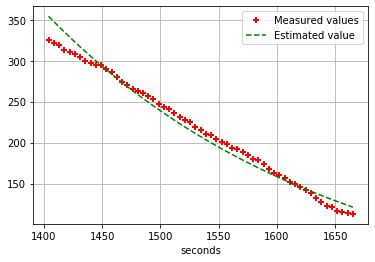

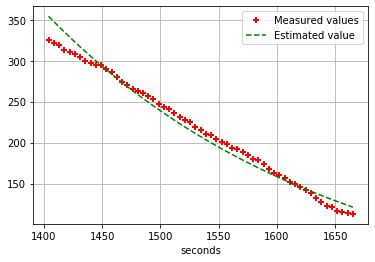

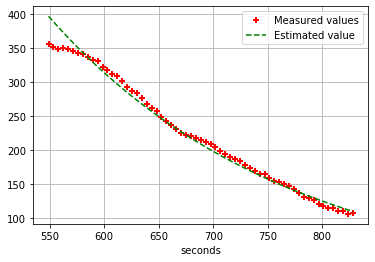

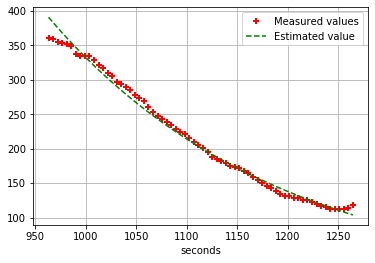

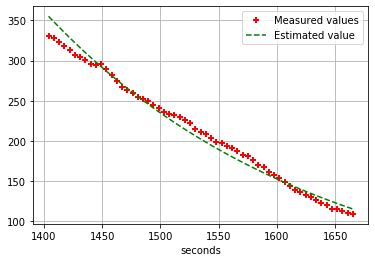

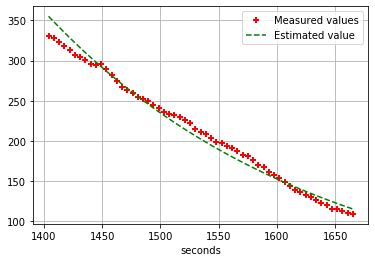

In [92]:
#     '''This function finds a tList in sec yList - measurements ySS - the steady state value of y returns amplitude of exponent tau - the time constant'''

def fitExponent(tList,yList,ySS=0):
    bList = [log(max(y-ySS,1e-6)) for y in yList]
    (w,residuals,rank,sing_vals) = lstsq(matrix([[1,t] for t in tList]),matrix(bList).T)
    tau = -1.0/w[1,0]
    amplitude = exp(w[0,0])
    return (amplitude,tau)

# Aplico la función para tau a la selección

wc_tau = []
for peak in range  (0, cantidad_total_picos - 1):
    x = (x_data[whole_cell_tiempos_maximos[peak]:wc_tiempos_minimos[peak+1]]) * x_calibracion
    y = np.asarray(whole_cell_data[whole_cell_tiempos_maximos[peak]:wc_tiempos_minimos[peak+1]],dtype=np.float64)
    (amplitudeEst,tauEst) = fitExponent(x,y)
    ySS=0
    yEst = amplitudeEst*(exp(-x/tauEst))+ySS
    wc_tau.append (tauEst)
# x = x_data[int(wc['Transient_' + str(cantidad_total_picos - 1)][0]):int(wc_tiempo_n[0])]
# y = np.asarray(whole_cell_data[int(wc['Transient_' + str(cantidad_total_picos - 1)][0]):int(wc_tiempo_n[0])],dtype=np.float64)
# (amplitudeEst,tauEst) = fitExponent(x,y,ySS)
# yEst = amplitudeEst*(exp(-x/tauEst))+ySS
wc_tau.append ('NaN')
wc.loc[len(wc)] = wc_tau


# Aplico la función para tau a los cortes de la selección

lista_tau = []
for img_row_sum in list_img_row:
    tau_frame = []
    for peak in range  (0, cantidad_total_picos - 1):
        x = (x_data[tiempos_maximos['Pico_' + str(peak)][0]:tiempos_minimos['Pico_' + str(peak+1)][0]]) * x_calibracion
        y = np.asarray(img_row_sum[tiempos_maximos['Pico_' + str(peak)][0]:tiempos_minimos['Pico_' + str(peak+1)][0]],dtype=np.float64)
        (amplitudeEst,tauEst) = fitExponent(x,y,ySS)
        yEst = amplitudeEst*(exp(-x/tauEst))+ySS
        tau_frame.append (tauEst)
        plt.figure(1)
        plt.plot(x,y,'+r',markersize=6,markeredgewidth=2)
        plt.plot(x,yEst,'--g')
        plt.xlabel('seconds')
        plt.legend(['Measured values','Estimated value'])
        plt.grid(True)
        plt.show()

#     x = x_data[tiempos_maximos['Pico_' + str(cantidad_total_picos - 1)][0]:tiempos_minimos['Pico_n'][0]]
#     y = np.asarray(img_row_sum[tiempos_maximos['Pico_' + str(cantidad_total_picos - 1)][0]:tiempos_minimos['Pico_n'][0]],dtype=np.float64)
#     (amplitudeEst,tauEst) = fitExponent(x,y,ySS)
#     yEst = amplitudeEst*(exp(-x/tauEst))+ySS
    tau_frame.append ('NaN')
    plt.figure(1)
    plt.plot(x,y,'+r',markersize=6,markeredgewidth=2)
    plt.plot(x,yEst,'--g')
    plt.xlabel('seconds')
    plt.legend(['Measured values','Estimated value'])
    plt.grid(True)
    plt.show()
    lista_tau.append (tau_frame)

Columns = ['Pico_'+ str(x) for x in range(0,len(tau_frame))]
taus = pd.DataFrame(lista_tau,columns = Columns)

taus.to_csv(path + 'tau_' + nombre_foto + '.csv',sep="\t", decimal=',')

In [93]:
# Relación entre la amplitud del pico2 sobre el pico1

wc_amplitudes_ratio = []
for ratio in range  (0 , cantidad_total_picos-1):
    wc_amp_ratio = wc ['Transient_' + str(ratio+1)][4] / wc ['Transient_' + str(ratio)][4]
    wc_amplitudes_ratio.append(wc_amp_ratio)
wc_amplitudes_ratio.append('NaN')
wc.loc[len(wc)] = wc_amplitudes_ratio         


# Relación entre la amplitud del pico2 sobre el pico1 de selección

amplitudes_ratio = pd.DataFrame()
for ratio in range  (0 , cantidad_total_picos-1):
    amp_ratio = amplitudes ['Pico_' + str(ratio+1)] / amplitudes ['Pico_' + str(ratio)]
    amplitudes_ratio['Pico_' + str (ratio+1) + '/Pico_' + str (ratio)] = amp_ratio
for ratio in range (cantidad_total_picos - 1):
    amplitudes_ratio [''] = 'NaN'

amplitudes_ratio.to_csv(path + 'amplitudes_ratio_' + nombre_foto + '.csv',sep="\t", decimal=',')

##############################################################################################################################################            

In [95]:
tmax_values = tiempos_maximos.values
tmin_values = tiempos_minimos.values
int_max_values = intensidades_maximas.values
int_min_values = intensidades_minimos.values
amp_values = amplitudes.values
ratio_amp_values = amplitudes_ratio.values
tpic_values = tiempo_al_pico.values
t50pic_values = tiempo_50pico.values
taus_values = taus.values

# En esta celda se arma una matriz que tiene por cada feta que se tomo de la imagen,
# los picos que se midieron en esa feta y para cada pico, un conjunto de metricas 
# que se midieron en celdas anteriores

feta_por_picos = []
for index in range(len(tmax_values)):

    tmax_feta = tmax_values[index] * x_calibracion
    tmin_feta = tmin_values[index] * x_calibracion
    int_max_feta = int_max_values[index]
    int_min_feta = int_min_values[index]
    amp_feta = amp_values[index]
    ratio_amp_feta = ratio_amp_values [index]
    tpic_feta = tpic_values[index] * x_calibracion
    t50pic_feta = t50pic_values[index] * x_calibracion
    taus_feta = taus_values[index]

    pico_por_metricas = ['tmax','tmin','intmax','intmin','amp','ratioamp','tpic','t50pic','tau']
    for index in range(len(tmax_feta)):
        pico_por_metricas.append([
            tmax_feta[index],
            tmin_feta[index],
            int_max_feta[index],
            int_min_feta[index],
            amp_feta[index],
            ratio_amp_feta [index],
            tpic_feta[index],
            t50pic_feta[index],
            taus_feta[index]
        ])

    feta_por_picos.append(pico_por_metricas)

In [96]:
with open(path + 'Tabla_general' + nombre_foto + '.txt', "w") as f:
    wr = csv.writer(f)
    wr.writerows(feta_por_picos)

cols = wc.columns[0:cantidad_picos]
wc_select = wc[cols]
index_wc = ['Tiempo maximo','Intensidad maximo','Tiempo minimo','Intensidad minimo','Amplitud','Tiempo al pico', 'Tau','Rel. ampitudes']
wc_select['parametros'] = index_wc
wc_select = wc_select.set_index('parametros')
wc_select.to_csv(path + 'whole_cell_data' + nombre_foto + '.csv',sep="\t", decimal=',')